# <center> Yelp Business Reviews for Downtown Chicago in EdgeDB </center>

**Chris Caldwell** <br>
**Last Edit: 12/18/2024**

## Objectives:

- Use a Google Maps API tool to obtain latitude and longitude coordinates from street addresses (reverse geocoding)
- Use EdgeDB to create the Graph-Relational Data Model for Yelp data (Businesses and Reviews); this involves using the EdgeDB Schema Definition Language
- Use EdgeDB with EdgeQL queries

## Project Prerequisites:
    
- Set up a working directory with this notebook saved.
- Install EdgeDB by following the instructions at: https://www.edgedb.com/docs/intro/quickstart.
- Create a Google Developer Account and obtain a `geocoder.ApiKey` for Google Maps.
- Navigate to the working directory from a console/terminal window.
- Execute EdgeDB commands from the console/terminal window to set up the EdgeDB database.  See "EdgeDB Development & Build Instructions" below.

### EdgeDB Development & Build Instructions:

- From the working directory, execute the following commands to set up the EdgeDB database schema:
    - To locate the EdgeDB system files:
        - `edgedb info`
    - Ensure that the following files are in your working directory:
        - `dbschema/default.esdl`
          - EdgeDB Schema Definition Language (SDL) file
          - Further info: https://docs.edgedb.com/database/reference/sdl
        - `edgedb.toml`
              - Configuration file
    - To initialize the database project:
        - `edgedb project init`
    - To verify that the project has been defined in the active working directory:
        - `edgedb project info`
    - To prepare for populating the database and running queries:
        - `edgedb migration create`
        - `edgedb migrate`
    - Note that there will now be a `dbschema/migrations` subdirectory containing a query file with the `.edgeql` extension, for example:
        - `00001.edgeql`
    - To check information about the database structure:
        - `edgedb list types`
    - To explore the unpopulated database structure with the EdgeDB GUI:
        - `edgedb ui`
    - For help with the EdgeDB Command Line Interface:
        - `edgedb help`
    - If desired, the EdgeDB instance can be unlinked at the end of the project with:
        - `edgedb project unlink`
        - Further system tidying could be achieved by destroying the instances:
            - View list of instances: `edgedb instance list`
            - Destroy an instance: `edgedb instance destroy -I "your_instance_name" --force`

### Configure Instance Authentication via EdgeDB UI:

- Open the REPL within the GUI to execute configuration commands:
    - In the EdgeDB GUI, find and open the "REPL" or "Console" to access the command interface.
    - Paste and execute the following EdgeQL command to configure instance authentication for passwordless access:
        ```edgeql
        configure instance insert Auth {
            comment := 'passwordless access',
            priority := 1,
            method := (insert Trust),
        };
        ```
    - This command sets up an authentication method allowing passwordless access, useful for development environments or specific secure contexts. Ensure this configuration aligns with your security and operational policies.

### Install EdgeDB Python Package:

Uncomment and execute the cell below to install the EdgeDB Python package:

In [75]:
#! pip install edgedb

## Yelp Data

-  To get information about Yelp Fusion API and Yelp's GraphQL API, go to: __[FAQ](https://www.yelp.com/developers/faq)__  

- Yelp Fusion API documentation:  __[Documentation Link](https://www.yelp.com/developers/documentation/v3/get_started)__ 

## Graph Database Schema

See below for a high-level data schema for this project.

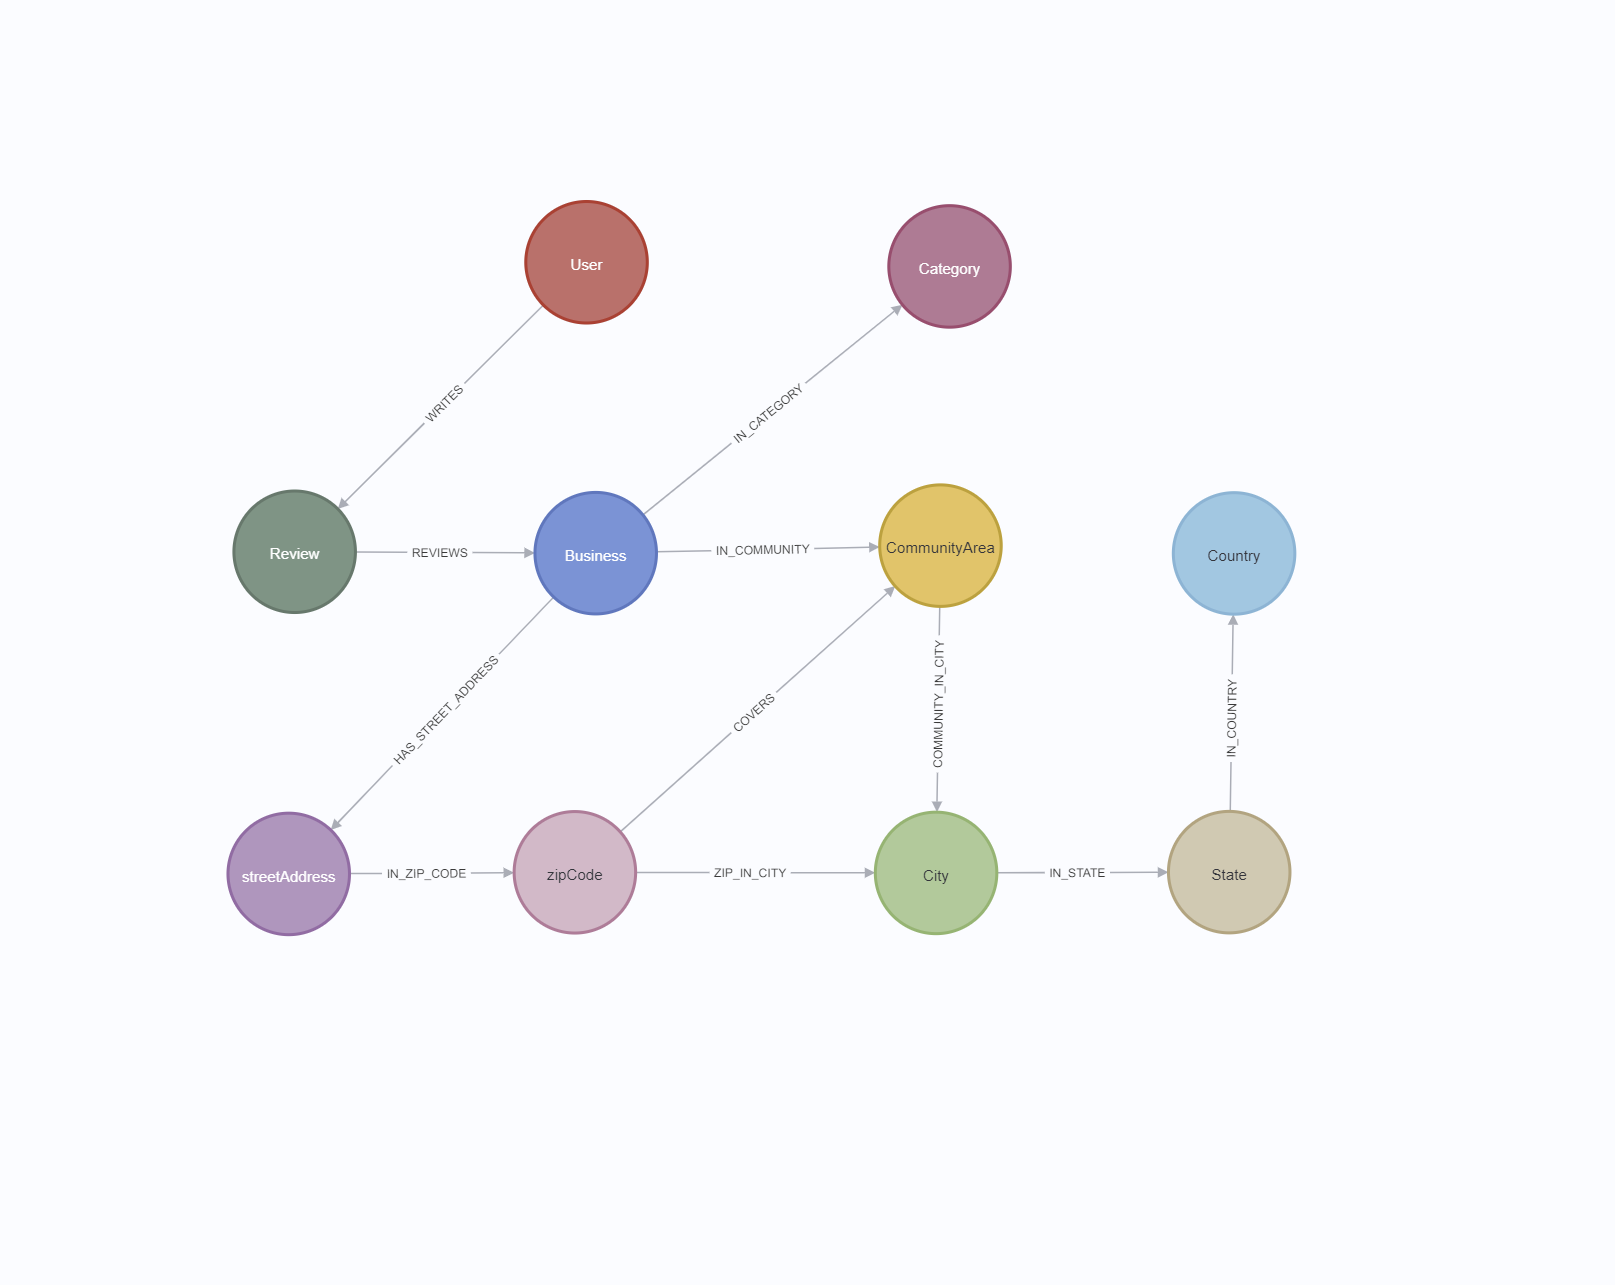




### Yelp Datasets (Businesses and Reviews) are documented in detail at  the following URL:

- https://www.yelp.com/dataset/documentation/main

Please note that the dataset for this project was collected using **YELP Fusion API** rather than Yelp's online datasets.

Chicago Yelp Reviews Datasets (Businesses and Reviews) are composed of two JSON files:

- **chicago_yelp_reviews.json** : businesses reviewed for Chicago Downtown Area
- **chicago_business_reviews.json** : 3 review excerpts collected from Yelp for every reviewed business in Chicago Downtown Area

The business_id is the common attribute/field between the two datasets.

## Chicago Community Areas

We are interested in the community areas of downtown Chicago:

- Chicago Loop
- West Town
- Near North Side Chicago
- Near South Side Chicago
- Near West Side Chicago


You can see the official list for the Boundaries of different Community Areas at the following URL:

- https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Community-Areas-current-/cauq-8yn6

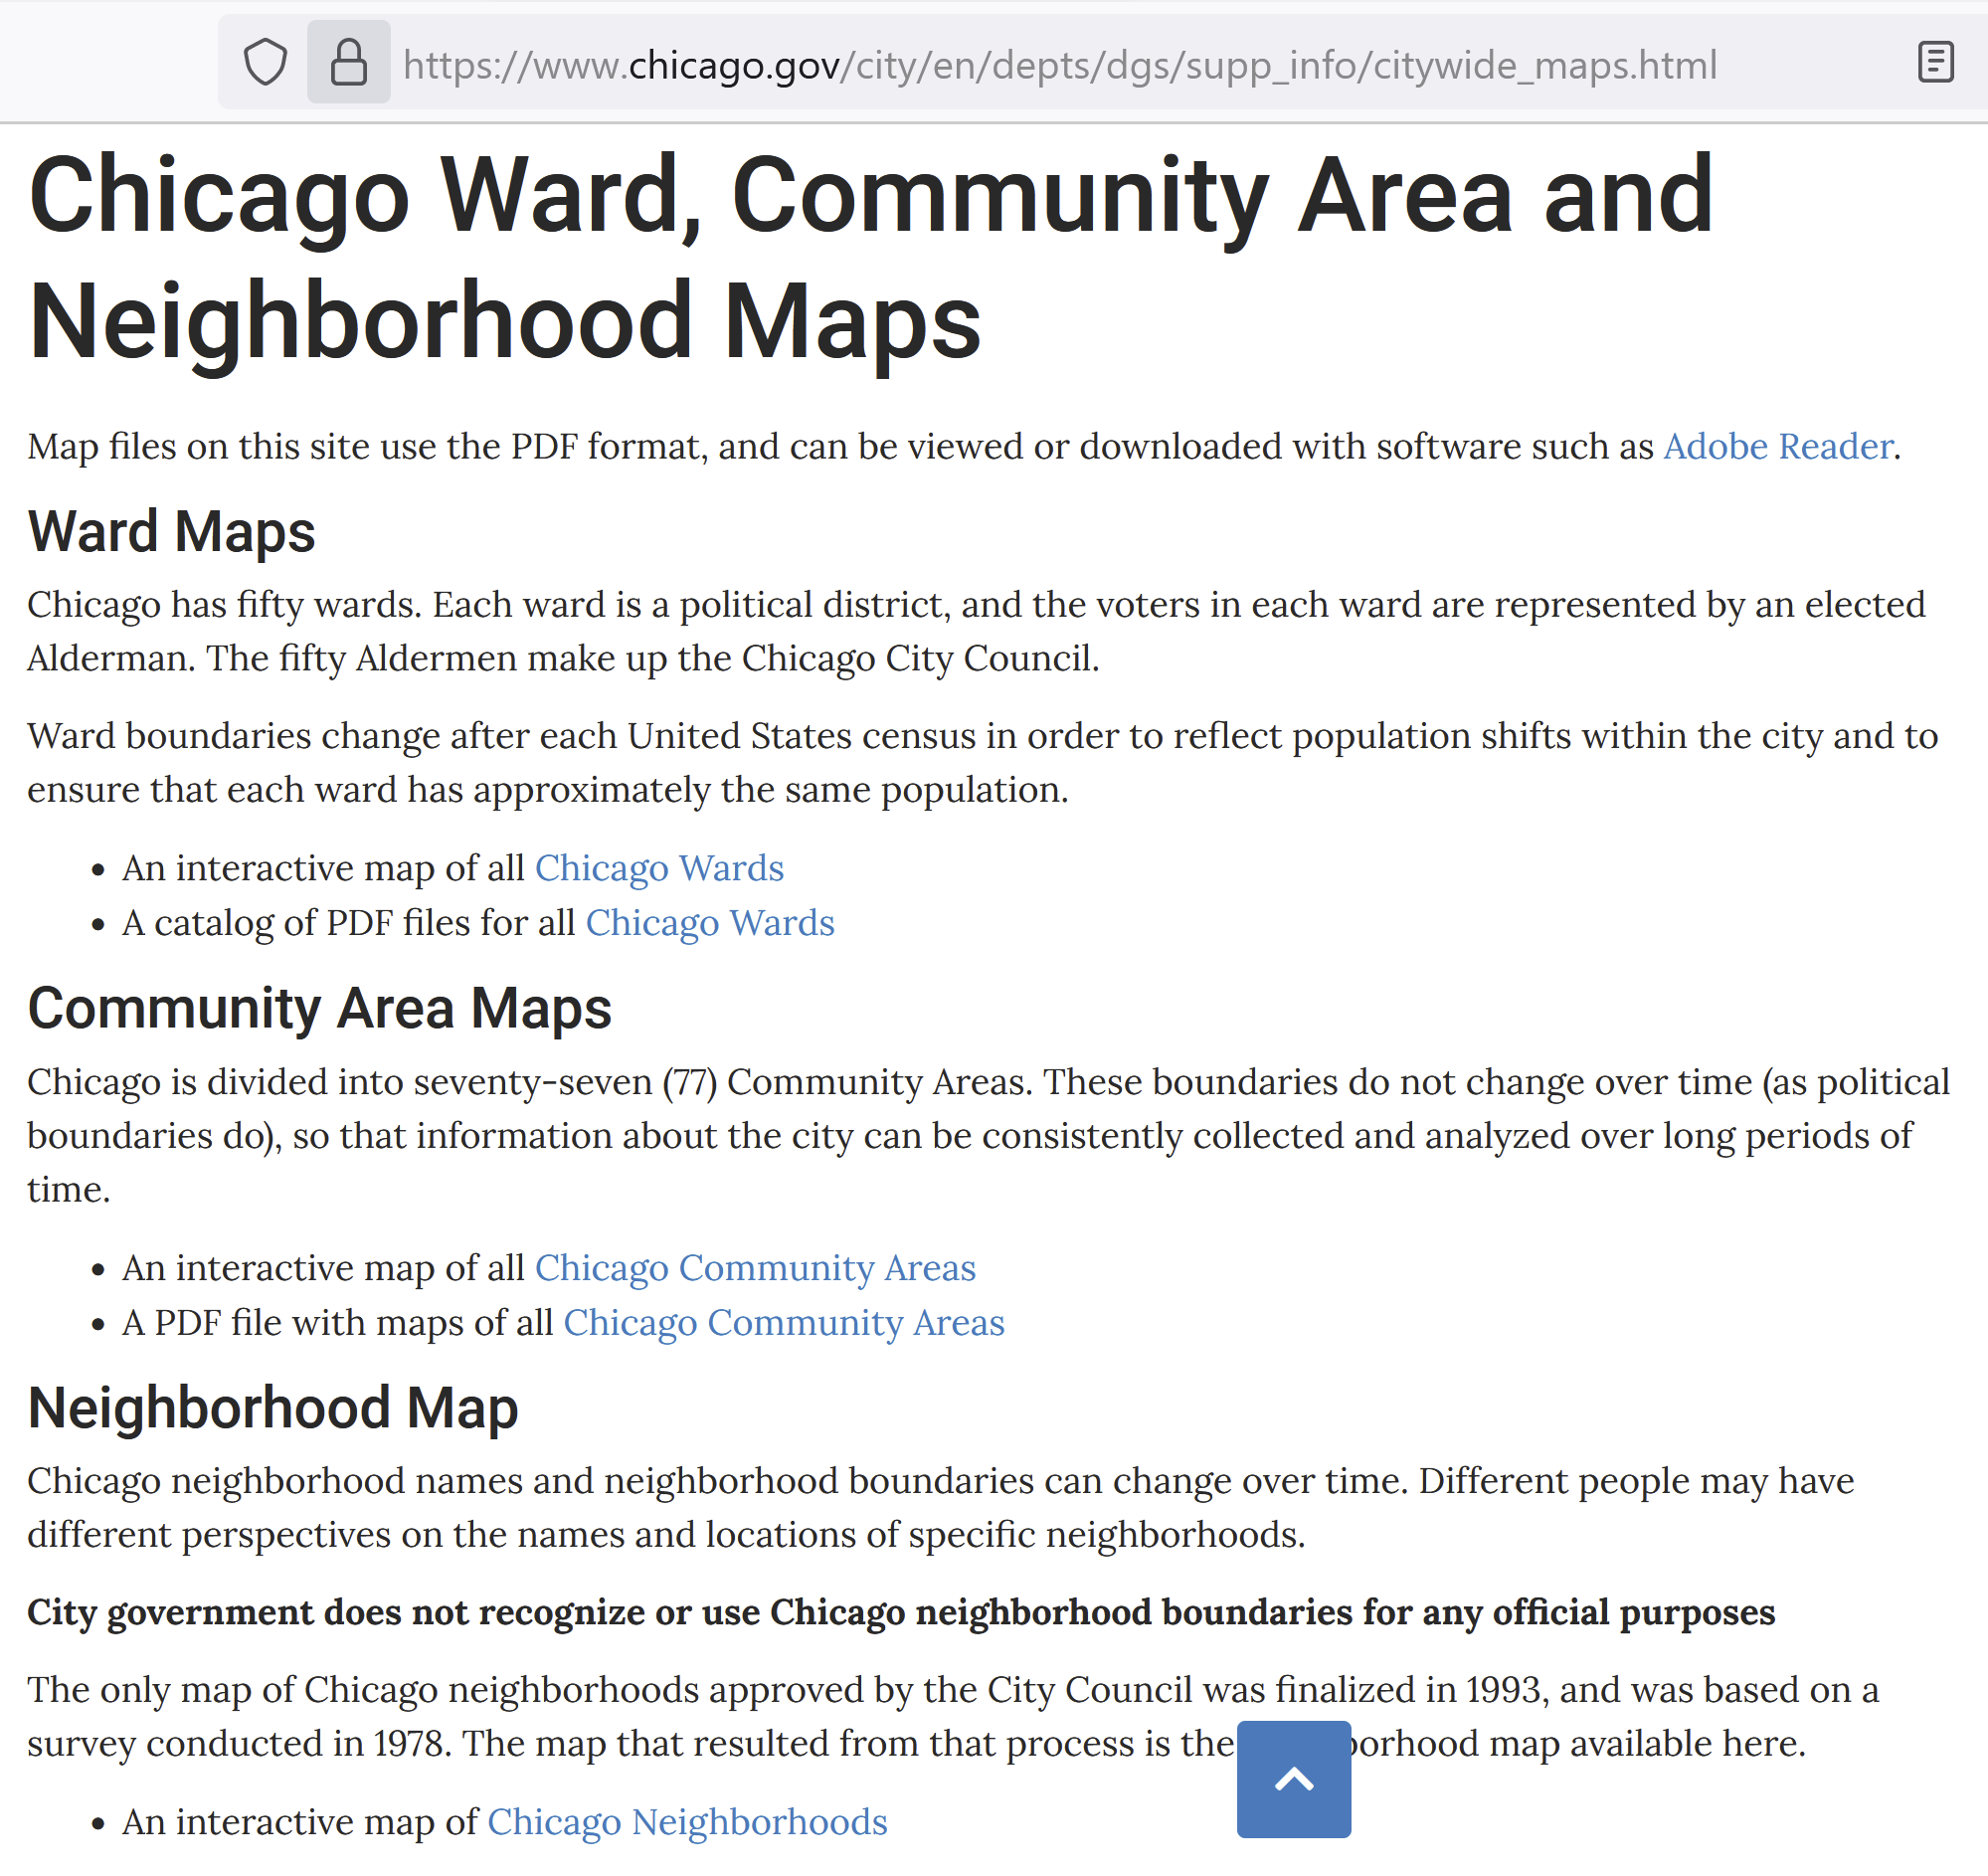


### Google Developer Account

- A Google Developer account and Geocoder API key are needed to do reverse lookup latitiude/logitude to cross-reference Address/Zip-Code/Community Area
- Create Google Developer Account and get a geocoder.ApiKey from the following URL:
https://developers.google.com/maps/documentation/geocoding/get-api-key
- Add the geocoder.ApiKey in the Python cell replacing the string "ADD-YOUR-API-KEY-HERE" 
- Use the latitude and longitude in geocoder.GeocodingReverse to find the zip-code 
- Docuemntation about the Geocoder here: (https://geocoder.readthedocs.io/providers/Google.html#geocoding)

### Business Categories
There are certain categories that are recognized by Yelp and indexed in their reviews.

Visit the following URLs to see the list:
- https://docs.developer.yelp.com/docs/resources-categories
- https://docs.developer.yelp.com/reference/v3_all_categories 

Data for businesses in the following categories was collected:
- Restaurants
- Entertainment
- Nightlife


In [81]:
from pprint import pprint
import datetime
import edgedb
import time
import warnings
# EdgeDB queries hit you with a lot of very ignorable warnings
warnings.filterwarnings('ignore')
import pandas as pd
import json

df__business_reviews = pd.DataFrame()

list__business_reviews_documents = []

## Chicago Downtown Neighborhoods and Zip-Codes


- A complete list of downtown Chicago zip codes is found at the follwoing URL:
    - https://www.seechicagorealestate.com/chicago-zip-codes-by-neighborhood.php



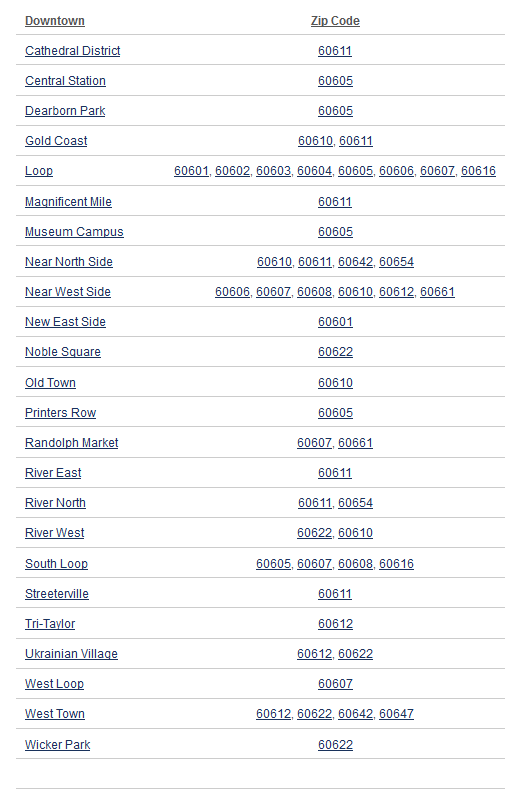

- The following URL has the complete list of the 77 Community Areas for the City of Chicago
    - https://en.wikipedia.org/wiki/Community_areas_in_Chicago

## Dataset #1 to Build the Database

### Read the provided chicago_yelp_reviews.json dataset and load into a dataframe object
### The dataset has the businesses reviewed on Yelp for the Chicago Downtown area

In [87]:
# Load the JSON data from a file
file_path = 'chicago_yelp_reviews.json'

# Open the file and read line by line
with open(file_path, 'r') as file:
    for line in file:
        # Parse each line as JSON and append to the list
        list__business_reviews_documents.append(json.loads(line))

# Convert the list of dictionaries to a DataFrame
df= pd.DataFrame(list__business_reviews_documents)

source_df = pd.json_normalize(df['source'])

df_businesses = df.drop(columns=['id','source']).join(source_df)

In [88]:
# Display the business info DataFrame
df_businesses

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,transactions,...,coordinates.latitude,coordinates.longitude,location.address1,location.address2,location.address3,location.city,location.zip_code,location.country,location.state,location.display_address
0,lxE3OEbLWnGP1pUrNzlgEw,maggie-roeder-cakes-chicago,Maggie Roeder Cakes,https://s3-media1.fl.yelpcdn.com/bphoto/kCFZvt...,False,https://www.yelp.com/biz/maggie-roeder-cakes-c...,6,"[{'alias': 'desserts', 'title': 'Desserts'}]",5.0,[],...,41.886260,-87.622310,,,,Chicago,60601,US,IL,"[Chicago, IL 60601]"
1,A_MAASk8gTKs9pxncdQ8pQ,rhoyal-decadence-chicago,Rhoyal Decadence,https://s3-media1.fl.yelpcdn.com/bphoto/aj6XOh...,False,https://www.yelp.com/biz/rhoyal-decadence-chic...,6,"[{'alias': 'desserts', 'title': 'Desserts'}]",5.0,[],...,41.876819,-87.634513,,,,Chicago,60610,US,IL,"[Chicago, IL 60610]"
2,oFIaLAJeuwyZpd_fnZaRag,miro-statue-chicago,Miro Statue,https://s3-media4.fl.yelpcdn.com/bphoto/9fKDmU...,False,https://www.yelp.com/biz/miro-statue-chicago?a...,5,"[{'alias': 'publicart', 'title': 'Public Art'}...",5.0,[],...,41.882995,-87.630474,69 W Washington St,,None,Chicago,60602,US,IL,"[69 W Washington St, Chicago, IL 60602]"
3,TbgVKWOfQM_I1ilh6XNUIQ,tns-pop-shop-chicago,TNS Pop Shop,https://s3-media2.fl.yelpcdn.com/bphoto/dM9GZb...,False,https://www.yelp.com/biz/tns-pop-shop-chicago?...,11,"[{'alias': 'desserts', 'title': 'Desserts'}, {...",5.0,[],...,41.877941,-87.629356,,None,None,Chicago,60604,US,IL,"[Chicago, IL 60604]"
4,doQumCZnwiWj3RbwW81SUA,mindworks-chicago-2,Mindworks,https://s3-media3.fl.yelpcdn.com/bphoto/kxqt6M...,False,https://www.yelp.com/biz/mindworks-chicago-2?a...,10,"[{'alias': 'museums', 'title': 'Museums'}, {'a...",5.0,[],...,41.878780,-87.624890,224 S Michigan Ave Chicago Il 60604,None,,Chicago,60604,US,IL,"[224 S Michigan Ave Chicago Il 60604, Chicago,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,mhfLifyOVfK8VbUwMNH7TQ,ketel-one-club-chicago,Ketel One Club,https://s3-media4.fl.yelpcdn.com/bphoto/9Jx3NA...,False,https://www.yelp.com/biz/ketel-one-club-chicag...,16,"[{'alias': 'tradamerican', 'title': 'American'}]",3.0,[],...,41.881195,-87.674409,1901 W Madison St,,The United Center,Chicago,60612,US,IL,"[1901 W Madison St, The United Center, Chicago..."
1997,qZsUJ3WRVbSkM-lWO5LVoA,shehed-bakery-chicago-2,Shehed Bakery,https://s3-media1.fl.yelpcdn.com/bphoto/inY_YC...,False,https://www.yelp.com/biz/shehed-bakery-chicago...,1,"[{'alias': 'bakeries', 'title': 'Bakeries'}, {...",4.0,[],...,41.883983,-87.705639,135 N Kedzie Ave,None,None,Chicago,60612,US,IL,"[135 N Kedzie Ave, Chicago, IL 60612]"
1998,j5wLsTnvuD1voV9W0Dl32Q,sbarro-chicago-15,Sbarro,https://s3-media2.fl.yelpcdn.com/bphoto/6KPDZG...,False,https://www.yelp.com/biz/sbarro-chicago-15?adj...,1,"[{'alias': 'pizza', 'title': 'Pizza'}]",4.0,[delivery],...,41.871316,-87.669862,1717 W Polk St,None,None,Chicago,60612,US,IL,"[1717 W Polk St, Chicago, IL 60612]"
1999,I37aZuiMpvQvQDJFkzZxnQ,tempesta-chicago-2,Tempesta,https://s3-media4.fl.yelpcdn.com/bphoto/dXaEHU...,False,https://www.yelp.com/biz/tempesta-chicago-2?ad...,1,"[{'alias': 'italian', 'title': 'Italian'}]",4.0,"[delivery, pickup]",...,41.891170,-87.661817,433 W Van Buren St,,None,Chicago,60607,US,IL,"[433 W Van Buren St, Chicago, IL 60607]"


In [89]:
df_businesses.describe()

,review_count,rating,distance,coordinates.latitude,coordinates.longitude
count,2001.000000,2001.000000,2001.000000,2001.000000,2001.000000
mean,215.496252,3.927886,1203.364428,41.880323,-87.640107
std,529.505377,0.696399,797.907298,0.020229,0.016972
min,1.000000,1.000000,19.911342,41.830179,-87.706481
25%,12.000000,3.500000,612.860415,41.869080,-87.648830
50%,56.000000,4.000000,1014.525707,41.881100,-87.634410
75%,217.000000,4.400000,1761.269317,41.886540,-87.628345
max,10096.000000,5.000000,5453.081964,41.927330,-87.606944


## Chicago-Style Food

Chicago is renowned for its **Chicago-style pizza**, and you can learn more about the origins of this term by reading the Chicago Tribune article available at [this link](https://www.chicagotribune.com/news/ct-xpm-2009-02-18-0902180055-story.html). The city is also known for its Chicago-style hot dogs, which you can read about on [Wikipedia](https://en.wikipedia.org/wiki/Chicago-style_hot_dog).

Visitors to Chicago often seek to experience these two iconic dishes that bear the city's culinary signature:
- Pizza
- Hot Dogs

For illustration purposes, let's consider the following two famous restaurants in downtown Chicago:
- Portillo's - Known for Chicago-Style Hot Dogs
- Giordano's - The Starbucks of Chicago-Style Pizza.  It's fine but you can do better.

**Note 1:**
Some business names may appear multiple times, which could lead to the mistaken belief that the dataset contains redundant entries. However, a restaurant chain might use the same business name for different locations, a detail that is captured under the alias field.

Here is an example for Potbelly Sandwich Shop:

- 'alias': 'potbelly-sandwich-shop-chicago-25'
- 'name': 'Potbelly Sandwich Shop'

- 'alias': 'potbelly-sandwich-shop-chicago-10'
- 'name': 'Potbelly Sandwich Shop'

**Note 2:**
Yelp reviews may refer to business names with or without an **s** at the end. For example, you might see reviews mentioning the business names either as "Portillo's" or "Portillo" and "Giordano's" or "Giordano".  Bumpkins may also add the "'s" to a business name, referring to "Safeway's" instead of Safeway as one example.

In [91]:
df_businesses.name.value_counts()

name
Starbucks                42
Dunkin'                  27
Subway                   17
7-Eleven                 15
Jimmy John's             14
                         ..
Momentum Coffee           1
Veggie House              1
Daifuku Ramen             1
3 Little Pigs Chi         1
Hawkeye's Bar & Grill     1
Name: count, Length: 1729, dtype: int64

### Sample of JSON review data:

In [93]:
print('No. of review docs:', len(list__business_reviews_documents))
print('Sample documents:\n')
for i in range(3):
    print(list__business_reviews_documents[i])
    print('\n')

No. of review docs: 2001
Sample documents:

{'id': 'lxE3OEbLWnGP1pUrNzlgEw', 'source': {'id': 'lxE3OEbLWnGP1pUrNzlgEw', 'alias': 'maggie-roeder-cakes-chicago', 'name': 'Maggie Roeder Cakes', 'image_url': 'https://s3-media1.fl.yelpcdn.com/bphoto/kCFZvtk9jrqmj6DYqAcKaA/o.jpg', 'is_closed': False, 'url': 'https://www.yelp.com/biz/maggie-roeder-cakes-chicago?adjust_creative=j_3xxHM_fKdWcYKUO806vA&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=j_3xxHM_fKdWcYKUO806vA', 'review_count': 6, 'categories': [{'alias': 'desserts', 'title': 'Desserts'}], 'rating': 5.0, 'coordinates': {'latitude': 41.88626, 'longitude': -87.62231}, 'transactions': [], 'price': '$$', 'location': {'address1': '', 'address2': '', 'address3': '', 'city': 'Chicago', 'zip_code': '60601', 'country': 'US', 'state': 'IL', 'display_address': ['Chicago, IL 60601']}, 'phone': '', 'display_phone': '', 'distance': 324.6541824855661}}


{'id': 'A_MAASk8gTKs9pxncdQ8pQ', 'source': {'id': 'A_MAASk8gTKs9pxncdQ8pQ

# Dataset #2 to Build the Database

### Read the provided chicago_business_reviews.json dataset and load into a dataframe object
### The dataset has 3 review excerpts collected from Yelp for every business reviewed in the Chicago Downtown area

In [95]:
# Path to the business reviews JSON file
business_reviews_json_file_path = 'chicago_business_reviews.json'

# Read the business reviews from JSON file into a DataFrame
df__business_reviews = pd.read_json(business_reviews_json_file_path,
                                    orient='records', lines=True)


In [96]:
# display some reviews
df__business_reviews

,id,url,text,rating,time_created,user,business_id,business_name
0,9zDXJqWc5IqDKzq-MBXQRA,https://www.yelp.com/biz/maggie-roeder-cakes-c...,Maggie was wonderful! She created a beautiful...,5,2015-01-05 14:27:45,"{'id': 'cg-gj1-faPJH4Q3wfY8DAw', 'profile_url'...",lxE3OEbLWnGP1pUrNzlgEw,Maggie Roeder Cakes
1,beQ4WaRjY0s9wpljcyi4Xw,https://www.yelp.com/biz/maggie-roeder-cakes-c...,"I found Maggie by searching ""best carrot cake""...",5,2014-09-15 17:20:22,"{'id': 'FHfjAReTovbu0chLv-WGrQ', 'profile_url'...",lxE3OEbLWnGP1pUrNzlgEw,Maggie Roeder Cakes
2,YQeDidm8YSLz2j2nO3UmFA,https://www.yelp.com/biz/maggie-roeder-cakes-c...,Not only are the cakes gorgeous but they are t...,5,2011-05-25 09:10:27,"{'id': 'VDoOo3LnfJJkj5oX9eCsVw', 'profile_url'...",lxE3OEbLWnGP1pUrNzlgEw,Maggie Roeder Cakes
3,NWCgK6eRF_hwc9xzjQJhKA,https://www.yelp.com/biz/rhoyal-decadence-chic...,Deliciously decadent treats crafted with quali...,5,2021-02-22 11:28:59,"{'id': 'GbReQBHQL6gLL2xMcCCsjQ', 'profile_url'...",A_MAASk8gTKs9pxncdQ8pQ,Rhoyal Decadence
4,TBFTFLDYPEXS3tNj7mSpBg,https://www.yelp.com/biz/rhoyal-decadence-chic...,OMG. That's the first thing that comes to mind...,5,2021-02-18 14:40:58,"{'id': '_sBPa5ONKuzqR5459CnhKQ', 'profile_url'...",A_MAASk8gTKs9pxncdQ8pQ,Rhoyal Decadence
...,...,...,...,...,...,...,...,...
5666,ZgxSQmsTNfupRNzVsODVDg,https://www.yelp.com/biz/ketel-one-club-chicag...,"Great service!!!!!! Amazingly kind staff, gre...",5,2023-04-08 06:41:33,"{'id': '4fqk_SfYUfs8jghF8Qn29g', 'profile_url'...",mhfLifyOVfK8VbUwMNH7TQ,Ketel One Club
5667,1hSNJYRqPpBpuXwjGOJQaA,https://www.yelp.com/biz/ketel-one-club-chicag...,Sat there for 30 minutes couldn't even get a w...,1,2023-02-02 20:01:48,"{'id': 'y-Gxjq9v0fh81yWweEYkIA', 'profile_url'...",mhfLifyOVfK8VbUwMNH7TQ,Ketel One Club
5668,UvQxUOCYAW3WCx64yHh8qw,https://www.yelp.com/biz/shehed-bakery-chicago...,I stumbled upon this company at an artisan mar...,4,2023-12-03 19:41:12,"{'id': 's-yGhMIJTcW39FTTzc2_Eg', 'profile_url'...",qZsUJ3WRVbSkM-lWO5LVoA,Shehed Bakery
5669,oNW8CABLe8jcNLaWOk-0QQ,https://www.yelp.com/biz/sbarro-chicago-15?adj...,Quick Tip! Some sbarros sell breakfast. Typi...,4,2023-06-26 06:19:18,"{'id': 'nJ6c6Tcg7e5vpOdQa8mdqQ', 'profile_url'...",j5wLsTnvuD1voV9W0Dl32Q,Sbarro


## Installing the Geocoder Package


In [98]:
!pip install geocoder

Defaulting to user installation because normal site-packages is not writeable


### Use the EdgeDB Graphical User Interface (GUI) to Track Progress -

From the working project directory enter this command:
    - `edgedb ui`

Before populating the database there are 10 object types but a count of zero objects. The schema has been defined, but there is no data in the database.

In [100]:
# Sample code snippet to show you how you can do Geocoder Reverse Lookup

import geocoder
import requests
import json

geocoder.ApiKey = "ADD-YOUR-API-KEY-HERE" 

# Test the API Key for Girdano's Pizza on Rush street in downtown
# The result will be a long JSON output 

latitude_str = str(41.8840343)
longitude_str = str(-87.628081)

url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng='+latitude_str+','+longitude_str+'&key='+geocoder.ApiKey
response = requests.get(url).json()

for item in response['results']:
    pprint(item)  

{'address_components': [{'long_name': 'Washington',
                         'short_name': 'Washington',
                         'types': ['establishment',
                                   'point_of_interest',
                                   'subway_station',
                                   'transit_station']},
                        {'long_name': 'Chicago Loop',
                         'short_name': 'Chicago Loop',
                         'types': ['neighborhood', 'political']},
                        {'long_name': 'Chicago',
                         'short_name': 'Chicago',
                         'types': ['locality', 'political']},
                        {'long_name': 'Cook County',
                         'short_name': 'Cook County',
                         'types': ['administrative_area_level_2', 'political']},
                        {'long_name': 'Illinois',
                         'short_name': 'IL',
                         'types': ['administrative_area_lev

In [101]:
import edgedb

# Build the Database

- The following code will insert the objects into the database.
<br>
- It takes **20 minutes** to insert total of **13691** objects into the database.

In [134]:
import time
from warnings import filterwarnings

# suppressing the same connection warning a zillion times
filterwarnings('ignore')

client = edgedb.create_client()

# for review in final__list_business_reviews_documents:
# INSERT BusinessReviewsObject ...
count = 0
IDs = []
chicago_community_areas = ["Rogers Park", "West Ridge", "Uptown",
                           "Lincoln Square", "North Center", "Lake View",
                           "Lincoln Park", "Chicago Loop", "Near North Side",
                           "Edison Park", "Norwood Park", "Jefferson Park",
                           "Forest Glen", "North Park", "Albany Park",
                           "Portage Park", "Irving Park", "Dunning",
                           "Montclare", "Belmont Cragin", "Hermosa",
                           "Avondale", "Logan Square", "Humboldt Park",
                           "West Town", "Austin", "West Garfield Park",
                           "East Garfield Park", "Near West Side",
                           "North Lawndale", "South Lawndale",
                           "Lower West Side", "The Loop", "Loop",
                           "Near South Side", "Armour Square", "Douglas",
                           "Oakland", "Fuller Park", "Grand Boulevard",
                           "Kenwood", "Washington Park", "Hyde Park",
                           "Woodlawn", "South Shore", "Chatham", "Avalon Park",
                           "South Chicago", "Burnside", "Calumet Heights",
                           "Roseland", "Pullman", "South Deering", "East Side",
                           "West Pullman", "Riverdale", "Hegewisch",
                           "Garfield Ridge", "Archer Heights", "Brighton Park",
                           "McKinley Park", "Bridgeport", "New City",
                           "West Elsdon", "Gage Park", "Clearing", "West Lawn",
                           "Chicago Lawn", "West Englewood", "Englewood",
                           "Greater Grand Crossing", "Ashburn",
                           "Auburn Gresham", "Beverly", "Washington Heights",
                           "Mount Greenwood", "Morgan Park", "O'Hare",
                           "Edgewater"]

for i in range(min(2000, len(list__business_reviews_documents))):
    review = list__business_reviews_documents[i]
    if review['id'] in IDs:
        continue
    IDs.append(review['id'])
    count += 1
    if count % 49 == 0:
        time.sleep(1)
        
    community_area = 'Chicago'
    categories = []
    if review['source']['coordinates']['latitude'] != None and review['source']['coordinates']['longitude'] != None:
        coordinates = (review['source']['coordinates']['latitude'],
                       review['source']['coordinates']['longitude'])
    else:
        continue
    
    url = 'https://maps.googleapis.com/maps/api/geocode/json?latlng='+ str(review['source']['coordinates']['latitude'])+','+str(review['source']['coordinates']['longitude'])+'&key='+geocoder.ApiKey
    
    response = requests.get(url, verify=False).json()

    if response['results']:
        if response['results'][0] != None:
            for item in response['results'][0]['address_components']:
                if 'neighborhood' in item['types'] and item['long_name'] in chicago_community_areas:
                    community_area = item['long_name']
        for category in review['source']['categories']:
            if category['title'] not in categories:
                categories.append(category['title'])
            client.query("""
                INSERT Category {
                    name := <str>$name
                } unless conflict on .name
            """, name=category['title'])

        client.query("""
            INSERT Country {
                name := <str>$name
            } unless conflict on .name
        """, name=review['source']['location']['country'])

        client.query("""
            INSERT State {
                name := <str>$name,
                in_country := (
                    select Country
                    filter
                        .name = <str>$country_name
                    limit 1
                )
            } unless conflict on (.name, .in_country)
        """, name=review['source']['location']['state'], country_name=review['source']['location']['country'])

        client.query("""
            INSERT City {
                name := <str>$name,
                in_state := (
                    select State
                    filter
                        .name = <str>$state_name
                    limit 1
                )
            } unless conflict on (.name, .in_state)
        """, name=review['source']['location']['city'], state_name=review['source']['location']['state'])

        client.query("""
            INSERT CommunityArea {
                name := <str>$name,
                in_city := (
                    select City
                    filter
                        .name = <str>$city_name
                    limit 1
                )
            } unless conflict on (.name, .in_city)
        """, name=community_area, city_name=review['source']['location']['city'])

        client.query("""
            INSERT ZipCode {
                digits := <str>$digits,
                in_city := (
                    select City
                    filter
                        .name = <str>$city_name
                    limit 1
                ),
                in_communityArea := (
                    select CommunityArea
                    filter
                        .name = <str>$community_area_name
                    limit 1
                )
            } unless conflict on .digits else (
                update ZipCode
                  set {
                    in_communityArea += (
                        select CommunityArea
                        filter
                            .name = <str>$community_area_name
                        limit 1
                    )
                  }
                )
        """, digits=review['source']['location']['zip_code'],
                     city_name=review['source']['location']['city'],
                     community_area_name=community_area)

        client.query("""
            INSERT StreetAddress {
                address1 := <str>$address1,
                address2 := <str>$address2,
                address3 := <str>$address3,
                coordinates := """ + str(coordinates) + """,
                in_zipcode := (
                    select ZipCode
                    filter
                        .digits = <str>$zip_code
                    limit 1
                )
            } unless conflict on .coordinates
        """,
            address1=review['source']['location']['address1'] if review['source']['location']['address1'] else '',
            address2=review['source']['location']['address2'] if review['source']['location']['address2'] else '',
            address3=review['source']['location']['address3'] if review['source']['location']['address3'] else '',
            zip_code=review['source']['location']['zip_code'])
            
        client.query("""
            INSERT Business {
                ID := <str>$id,
                name := <str>$name,
                alias := <str>$alias,
                rating := <float32>$rating,
                review_count := <int32>$review_count,
                coordinates := """ + str(coordinates) + """,
                in_communityArea := (
                    select CommunityArea
                    filter
                        .name = <str>$community_area_name
                    limit 1
                ),
                has_address := (
                    select StreetAddress
                    filter
                        .coordinates.latitude = <float32>$latitude and .coordinates.longitude = <float32>$longitude 
                    limit 1
                ),
                in_category := (
                    select Category
                    filter
                        .name in array_unpack(<array<str>>$category_array)
                )
            } unless conflict on .ID
        """, id=review['id'], name=review['source']['name'],
                     alias=review['source']['alias'],
                     rating=review['source']['rating'],
                     review_count=review['source']['review_count'],
                     community_area_name=community_area,
                     latitude=coordinates[0], longitude=coordinates[1],
                     category_array=categories)
    
    business_reviews = df__business_reviews[df__business_reviews['business_id'] == review['id']]

    for _, business_review in business_reviews.iterrows(): 
        client.query("""
            INSERT User {
               user_id := <str>$user_id
            } unless conflict on .user_id
        """, user_id=business_review['user']['id'])
            
        client.query("""
                    INSERT Review {
                        review_id := <str>$review_id,
                        text := <str>$review_text,
                        rating := <float32>$rating,
                        time_created :=<str>$review_time_created,
                        reviews_business := (
                            SELECT Business
                            FILTER .ID = <str>$business_id
                            LIMIT 1
                        ),
                     written_by := (
                                SELECT User
                                FILTER .user_id = <str>$user_id
                                LIMIT 1
                            )
                    }
                """, review_id=business_review['id'], business_id=review['id'],
                     review_text=business_review['text'],
                     review_time_created=business_review['time_created'],
                     rating=business_review['rating'], user_id=business_review['user']['id'])
    
client.close()

filterwarnings('always')

<hr style="border:5px solid brown"> </hr>

### Note:

- If there are no errors, that means the insertion of the objects is completed successfully by now.
<br>
- Verify objects inserted into the database using the EdgeDB UI.

<hr style="border:5px solid brown"> </hr>


## Test Queries

### Query 1
- Retrieve all businesses with 5 stars from Yelp Graph-Relational Data Model 
- Compute the time it takes to execute this requirement with the Python EdgeQL client

In [138]:
# Write your code here

client = edgedb.create_client()

# Consider the following code snippet

# Start the timer
start_time = time.time()

reviews_with_rating_5 = client.query('SELECT Business {name} FILTER .rating = <float32>$rating', rating = 5)

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the time needed to execute the requirement
print(f'\n\n\t\t Total Execution Time:  {elapsed_time:.2f} seconds \n\n')

for review in reviews_with_rating_5:
   print(review.name)

client.close()



		 Total Execution Time:  2.07 seconds 


Maggie Roeder Cakes
Rhoyal Decadence
Miro Statue
TNS Pop Shop
Mindworks
Yelp Elite Battle Of The Band T's @ RAISED Urban Rooftop Bar
State Street, That Great Street
Auntie Anne's
Picasso Statue
7-Eleven
Marshall Field and Company Building
Brews & Bites
Ron Christian
Biker Dude
Cascade Park
Sneakerhead University
Farmer's Fridge
The Good Eating Company
Fashion Focus
Occupy Chicago
Field Museum Dig Site
Louise Nevelson's Dawn Shadows
Project Windows Design Contest
Washington-Morris-Salomon Monument
Marla's Mandel Bread
Chicago Temple Building
Flash UYE: Chicago Cultural Center
TourBound Golf Academy
TJ's Heavenly Sweet
Sweetling Cupcakes
Clark Johnson Orchestra
Wolverine Trading Kitchen
Porter's Steakhouse
The Flight of Daedalus and Icarus By Roger Brown 1991
The Member Bar at Terzo Piano
Wells Street Bridge
Chick-fil-A
Bagels Time
Salads UP
Marshall Suloway Bridge
Cupcakes & Cocktails
River North Association
Verve Coffee Roasters
Wings of Mexi

### Query 2
- Retrieve all businesses that offer **Pizza** in Zip-Code 60601  
- Compute the time it takes to execute this requirement with the Python EdgeQL client      

In [140]:
client = edgedb.create_client()

# Consider the following code snippet

# Start the timer
start_time = time.time()

# business is in zip code and name, review text, or category includes 'pizz'

q = '''
    SELECT Business {name}
    FILTER ZipCode.digits = <str>$zip_code
           AND (
                Business.has_reviews.text ilike <str>$search_term
                OR Business.in_category.name ilike <str>$search_term
                )
    ;
    '''


pizza_places = client.query(q, search_term = '%pizz%', zip_code = '60601')
# 'pizz' will hit pizza or pizzeria

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the time needed to execute the requirement
print(f'\n\n\t\t Total Execution Time:  {elapsed_time:.2f} seconds \n\n')

# print # of matches
print(f'\t\t Matches:  {len(pizza_places)}\n\n')

for business in pizza_places:
   print(business.name)

client.close()




		 Total Execution Time:  2.53 seconds 


		 Matches:  113


Terra e Mare
The Living Room
Amazon Go
Fontano's Subs and Pizzeria
Reggie's Pizza Express
Giordano's
Giordano's - Jackson
Exchequer Restaurant & Pub
O'Neil's on Wells
The Florentine
Luke's Italian Beef
Intermission Bar and Kitchen
Millennium Hall 
Boni Vino Ristorante & Pizzeria
Sopraffina Marketcaffe
Pizano's Pizza & Pasta
Blaze Pizza
The Halal Slice
Seven Bar and Restaurant
La Cocina
Rosati's Pizza
Urban Market
Potbelly Sandwich Shop
Bacci Pizzeria
Rosati's Pizza Chicago Downtown
Chi-Town Pizza Express
My TT Pizza
Lou Malnati's Pizzeria
Paisans Pizzeria
The Art of Pizza
Pat's Pizzeria
Roots Handmade Pizza - South Loop
Gino's East - South Loop
Sbarro
7-Eleven
Herb N' Kitchen
PieLife
Sono Wood Fired Chicago
On The Go Restaurant
AfterBar
Arturo Express
Victory Tap Chicago
Jet's Pizza
Fatpour Tap Works McCormick
Flo & Santos
Cafe Bionda
Connie's Pizza
Giordano's
Showroom Food Hall
Aurelio's Pizza South Loop
Sbarro
Williams In

### Query 3 
- Retrieve the top 5 businesses with the highest number of reviews that offer **Hot Dogs** in Zip Code 60601
- Measure the execution time of this requirement using the Python EdgeQL client.      

In [142]:
client = edgedb.create_client()

# Consider the following code snippet

# Start the timer
start_time = time.time()

# business is in zip code and name, review text, or category includes 'hot dog'

q = '''
    SELECT Business {name, review_count}
    FILTER ZipCode.digits = <str>$zip_code
           AND (
                Business.has_reviews.text ilike <str>$search_term
                OR Business.in_category.name ilike <str>$search_term
                OR Business.name ilike <str>$search_term
                )
    ORDER BY Business.review_count DESC
    LIMIT 5
    ;
    '''


hot_dogs = client.query(q, search_term = '%hot dog%', zip_code = '60601')

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the time needed to execute the requirement
print(f'\n\n\t\t Total Execution Time:  {elapsed_time:.2f} seconds \n\n')

# print # of matches
print(f'\t\t Matches:  {len(hot_dogs)}\n\n')

for business in hot_dogs:
   print(business.name, business.review_count)

client.close()





		 Total Execution Time:  2.57 seconds 


		 Matches:  5


Devil Dawgs -  South State 935
Portillo's Chicago - Canal and Taylor 859
Jim's Original 711
Chicago's Dog House 595
Kim & Carlo's Hot Dog Stand 364


### Query 4
- Get 3 review excerpts of the top 3 businesses with the highest number of reviews offering **Italian** food in Zip Code 60601
- Measure the execution time for this requirement using the Python EdgeQL client.

In [144]:
# step one get the restaurants with id

client = edgedb.create_client()

# Consider the following code snippet

# Start the timer
start_time = time.time()

# business is in zip code and name or category includes 'ital'
# 'ital' captures 'Italy' and 'Italian'

# I figure Italian is a specifically-defined enough cuisine that either the
# name or category should capture all Italian restaurants

q = '''
    SELECT Business {name, id, review_count}
    FILTER ZipCode.digits = <str>$zip_code
           AND (
                Business.in_category.name ilike <str>$search_term
                OR Business.name ilike <str>$search_term
                )
    ORDER BY Business.review_count DESC
    LIMIT 3
    ;
    '''


italian = client.query(q, search_term = '%ital%', zip_code = '60601')

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the time needed to execute the requirement
print(f'\n\n\t\t Total Execution Time:  {elapsed_time:.2f} seconds \n\n')

# print # of matches
print(f'\t\t Matches:  {len(italian)}\n\n')

for business in italian:
   print(business.name, business.review_count)

client.close()





		 Total Execution Time:  3.11 seconds 


		 Matches:  3


Giordano's 3755
Lou Malnati's Pizzeria 3129
Chicago Pizza And Oven Grinder Company 3073


In [145]:
start_time = time.time()

italian_reviews = []

for business in italian:
    
    q = '''
    SELECT Business { has_reviews: {text} }
    FILTER Business.id = <uuid>$bus_id
    ;
    '''
    italian_reviews.append(client.query(q, bus_id = business.id))

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the time needed to execute the requirement
print(f'\n\n\t\t Total Execution Time:  {elapsed_time:.2f} seconds \n\n')

for i in range(3):
    print('--------------------------------------------------------')
    print(italian[i].name)
    print(italian[i].review_count, 'reviews\n')
    for j in range(3):
        print('Review', j+1)
        print(italian_reviews[i][0].has_reviews[j].text,'\n')
    
    




		 Total Execution Time:  2.08 seconds 


--------------------------------------------------------
Giordano's
3755 reviews

Review 1
Chicago is known for their deep dish pizza which is why I made an effort to check out one of the many popular chains. With so many reviews it proved... 

Review 2
Yummy... I was so looking forward to coming here on this trip since I never had the chance to on previous visits. We got there kind of late (9:30-10pm-ish?)... 

Review 3
Giordano's has a great set up. You walk inside and there are 2 hostess 1 to put you on the wait list and one to take your pizza order since it does take a... 

--------------------------------------------------------
Lou Malnati's Pizzeria
3129 reviews

Review 1
My team came here for a nation meeting and conference and our manager took us out to Lou Malnatis pizzeria because, you have to when you're in Chicago!... 

Review 2
I surprisingly enjoyed the deep dish pizza here. Being from NY, I'm more of a thin crust pizza gal. I'

### Query 5
- Get the top 5 businesses with the highest number of reviews that offer **Hot Dogs** in the **Lincoln Park** Community Area
- Measure the execution time for this requirement using the Python EdgeQL client.  

In [147]:
client = edgedb.create_client()

# Consider the following code snippet

# Start the timer
start_time = time.time()

# business is in community area and name, review text, or category includes 'hot dog'

q = '''
    SELECT Business {name, review_count}
    FILTER Business.in_communityArea.name = <str>$community_area
           AND (
                Business.has_reviews.text ilike <str>$search_term
                OR Business.in_category.name ilike <str>$search_term
                OR Business.name ilike <str>$search_term
                )
    ORDER BY Business.review_count DESC
    LIMIT 5
    ;
    '''


hot_dogs = client.query(q, search_term = '%hot dog%', community_area = 'Lincoln Park')

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the time needed to execute the requirement
print(f'\n\n\t\t Total Execution Time:  {elapsed_time:.2f} seconds \n\n')

# print # of matches
print(f'\t\t Matches:  {len(hot_dogs)}\n\n')

for business in hot_dogs:
   print(business.name, '\tReviews:', business.review_count)

client.close()


C:\ProgramData\anaconda3\Lib\threading.py:248: ResourceWarning: unclosed <ssl.SSLSocket fd=6140, family=2, type=1, proto=0, laddr=('127.0.0.1', 61836), raddr=('127.0.0.1', 10700)>
  self.acquire = lock.acquire




		 Total Execution Time:  2.53 seconds 


		 Matches:  5


Five Guys 	Reviews: 311
Johnny's Beef & Gyros - Lincoln Park 	Reviews: 211
Fatso’s Last Stand 	Reviews: 97
Mochinut 	Reviews: 39
North and Clark Café 	Reviews: 24


I checked in the EdgeDB UI; Five Guys is in fact labeled in the Hot Dogs category.

### Query 6
- Get 3 reviews of the top 3 businesses with the highest number of reviews that offer **Greek** food in the Community Area **Chicago Loop**
- Measure the execution time for this requirement using the Python EdgeQL client.

In [150]:
# step one get the restaurants with id

client = edgedb.create_client()

# Consider the following code snippet

# Start the timer
start_time = time.time()

# business is in community area and name or category includes 'Greece'
# or 'Greek'
# a lot of common words like 'green' match 'gree' so we can't use the 'ital'
# method like we did for italian food

q = '''
    SELECT Business {name, id, review_count}
    FILTER Business.in_communityArea.name = <str>$community_area
           AND (
                Business.in_category.name ilike <str>$search_term1
                OR Business.name ilike <str>$search_term1
                OR Business.in_category.name ilike <str>$search_term2
                OR Business.name ilike <str>$search_term2
                )
    ORDER BY Business.review_count DESC
    LIMIT 3
    ;
    '''

greek = client.query(q,
                     search_term1 = '%greece%',
                     search_term2 = '%greek%',
                     community_area = 'Chicago Loop')

# Stop the timer
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the time needed to execute the requirement
print(f'\n\n\t\t Total Execution Time:  {elapsed_time:.2f} seconds \n\n')

# print # of matches
print(f'\t\t Matches:  {len(greek)}\n\n')

for business in greek:
   print(business.name, business.review_count)

client.close()



		 Total Execution Time:  5.71 seconds 


		 Matches:  3


Taza Cafe 665
Avli on the Park 242
Greek Kitchen 202


In [151]:
start_time = time.time()

greek_reviews = []

for business in greek:
    
    q = '''
    SELECT Business { has_reviews: {text} }
    FILTER Business.id = <uuid>$bus_id
    ;
    '''
    greek_reviews.append(client.query(q, bus_id = business.id))

end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the time needed to execute the requirement
print(f'\n\n\t\t Total Execution Time:  {elapsed_time:.2f} seconds \n\n')

for i in range(3):
    print('--------------------------------------------------------')
    print(greek[i].name)
    print(greek[i].review_count, 'reviews\n')
    for j in range(3):
        print('Review', j+1)
        print(greek_reviews[i][0].has_reviews[j].text,'\n')



		 Total Execution Time:  2.04 seconds 


--------------------------------------------------------
Taza Cafe
665 reviews

Review 1
Good, not great! I got takeout and the chicken sandwich fell apart by the time it got to me. The fries were very oily, and not crisp. I wouldn't order again... 

Review 2
My go to when I want quick and delicious lunch in the loop. Authentic flavors. Excellent service. Great family owned spot charging fair prices 

Review 3
hands down the nicest people! 

the food is absolutely amazing. the best fries I have ever had. 

--------------------------------------------------------
Avli on the Park
242 reviews

Review 1
A charming restaurant nestled in a beautiful park setting.  Hosts greeted us with sincere smiles and promptly seated us.  The indoor dining area is... 

Review 2
Can't climb stairs? Then you must be careful as it was a multiple back and forth finding the elevator and then making it work as the front desk just tells... 

Review 3
If you have not b